In [3]:
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
def eh_linha_valida(linha):
    if not linha or len(linha) < 8:
        return False
    
    if not linha[0] or not ('/' in linha[0] or linha[0].startswith(('DC', 'DMAT', 'DFIS'))):
        return False
    
    if not linha[1]:
        return False
    
    return any(i < len(linha) and linha[i] and any(c.isdigit() for c in linha[i]) for i in range(2, 5))


In [5]:
def extrair_dados_do_pdf(pdf_path, aluno_id):
    dados = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            tabelas = page.extract_tables()
            if tabelas:
                for tabela in tabelas:
                    for linha in tabela:
                        if eh_linha_valida(linha):
                            dados.append([aluno_id] + linha)
    return dados

In [6]:
def extrair_notas_pasta(pasta_pdfs, csv_completo):
    df_final = pd.DataFrame()
    arquivos_pdf = [f for f in os.listdir(pasta_pdfs) if f.endswith(".pdf")]
    
    for idx, arquivo in enumerate(sorted(arquivos_pdf), start=1):
        pdf_path = os.path.join(pasta_pdfs, arquivo)
        dados = extrair_dados_do_pdf(pdf_path, idx)
        df = criar_dataframe(dados)
        df_final = pd.concat([df_final, df], ignore_index=True)
    
    salvar_datasets(df_final, csv_completo)
    print(f"Dataset gerado com sucesso: {csv_completo}")

In [7]:
def criar_dataframe(dados):
    if not dados:
        return pd.DataFrame()
    
    max_cols = max(len(linha) for linha in dados)
    colunas = ["AlunoID", "Código", "Disciplina", "Unidade 1", "Unidade 2", "Unidade 3", "Unidade 4", "Unidade 5", "Prova Final", "Resultado", "Faltas", "Situação"]
    colunas = colunas[:max_cols] if max_cols <= len(colunas) else colunas + [f"Col{i}" for i in range(len(colunas)+1, max_cols+1)]
    
    return pd.DataFrame(dados, columns=colunas)

In [8]:
def salvar_datasets(df, csv_completo):
    df.to_csv(csv_completo, index=False)

In [9]:
if __name__ == "__main__":
    pasta_pdfs = "./NotasPDF"
    extrair_notas_pasta(pasta_pdfs, "Datasets/notas_alunos.csv")
    print("Processo concluído.")

Dataset gerado com sucesso: Datasets/notas_alunos.csv
Processo concluído.


Número total de alunos: 8
Número total de disciplinas: 70
Média geral das notas: 8.12
Média geral de faltas: 3.65
Aluno com maior média: 5
Aluno com menor média: 7

Situação dos alunos:
Situação
AM    297
RN     20
EF     20
RF      3
Name: count, dtype: int64


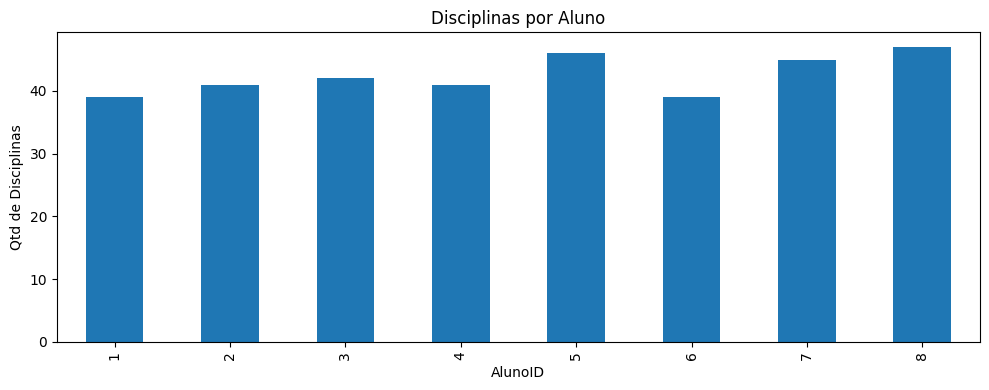

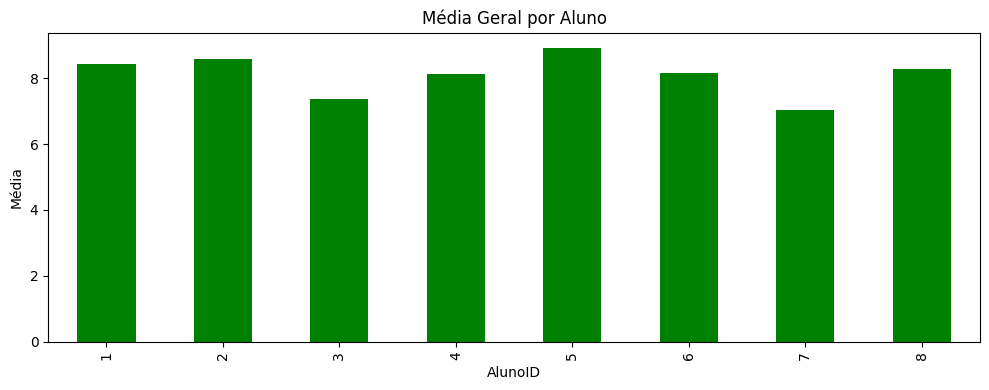

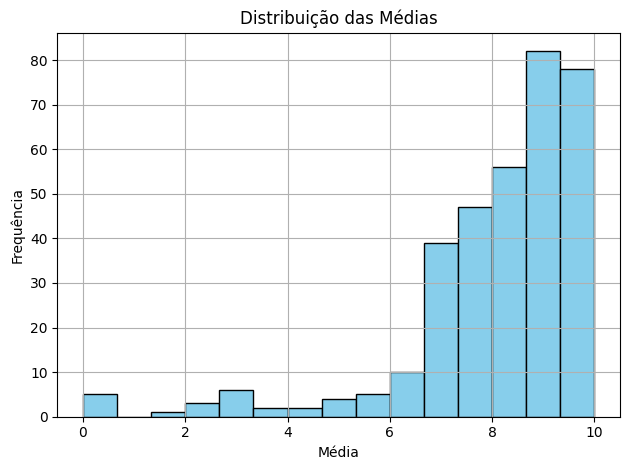

C:\Users\cclmp\AppData\Local\Temp\ipykernel_18704\4274493836.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=notas_long, x="Unidade", y="Nota", palette="pastel")


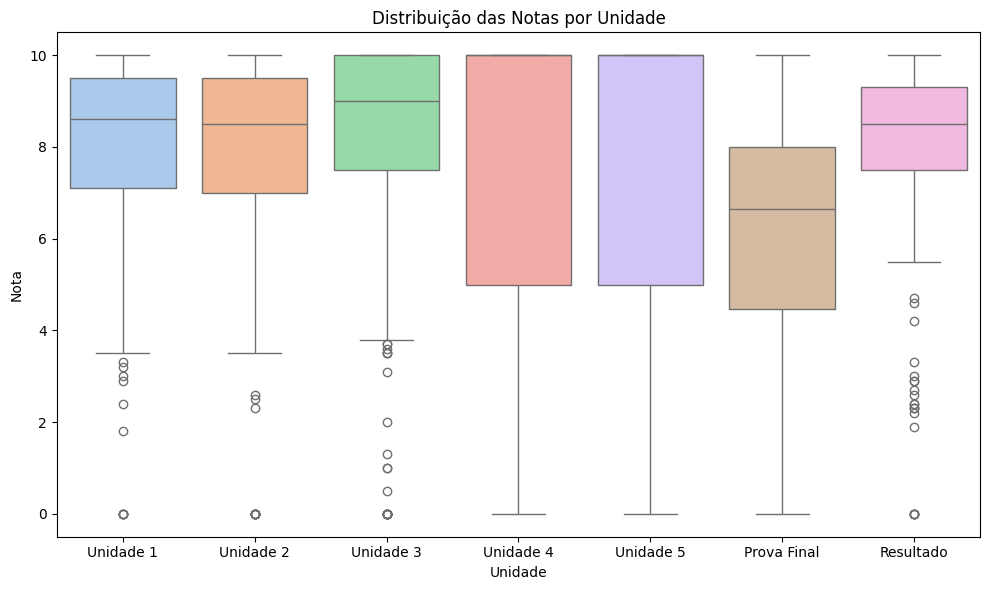

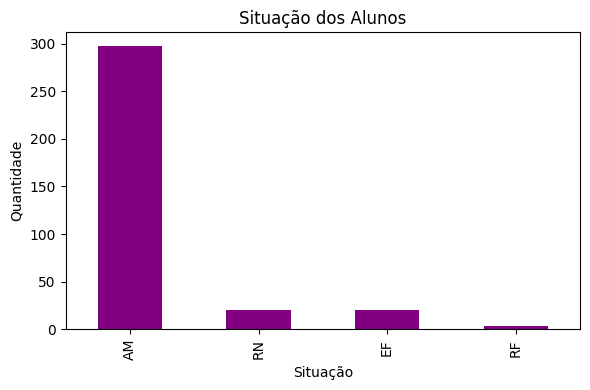

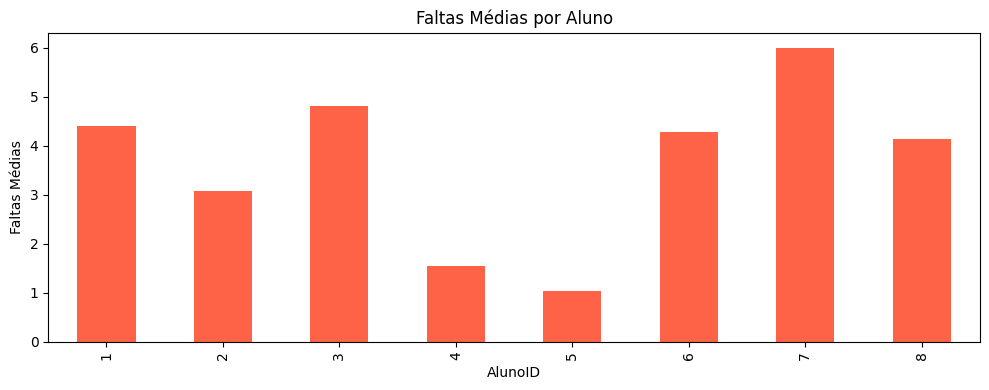

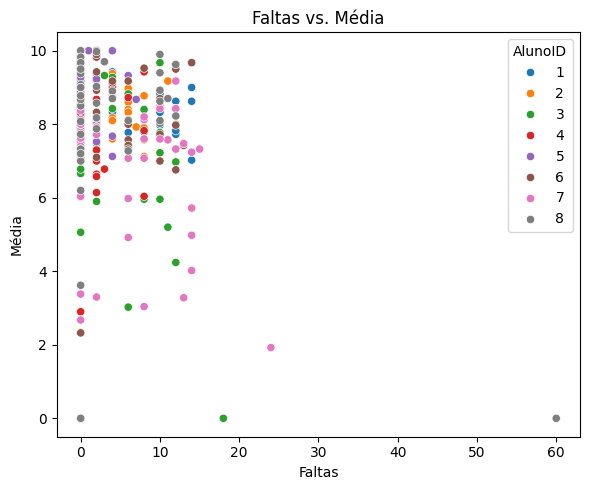

In [9]:
%matplotlib inline

def analisar_dados(caminho_csv="Datasets/notas_alunos.csv"):
    df = pd.read_csv(caminho_csv)
    df["AlunoID"] = df["AlunoID"].astype(str).str.strip().str.upper()


    colunas_notas = ["Unidade 1", "Unidade 2", "Unidade 3", "Unidade 4", "Unidade 5", "Prova Final", "Resultado"]
    for col in colunas_notas:
        if col in df.columns:
            df[col] = df[col].str.replace(",", ".").astype(float)

    df["Faltas"] = pd.to_numeric(df["Faltas"], errors="coerce")

    df["Média"] = df[colunas_notas].mean(axis=1, skipna=True)

    print("Número total de alunos:", df["AlunoID"].nunique())
    print("Número total de disciplinas:", df["Disciplina"].nunique())
    print("Média geral das notas:", round(df["Média"].mean(), 2))
    print("Média geral de faltas:", round(df["Faltas"].mean(), 2))
    
    aluno_melhor = df.groupby("AlunoID")["Média"].mean().idxmax()
    aluno_pior = df.groupby("AlunoID")["Média"].mean().idxmin()
    print(f"Aluno com maior média: {aluno_melhor}")
    print(f"Aluno com menor média: {aluno_pior}")

    print("\nSituação dos alunos:")
    print(df["Situação"].value_counts())

    # Disciplinas por aluno
    df["AlunoID"].value_counts().sort_index().plot(kind='bar', figsize=(10, 4), title="Disciplinas por Aluno")
    plt.xlabel("AlunoID")
    plt.ylabel("Qtd de Disciplinas")
    plt.tight_layout()
    plt.show()

    # Média geral por aluno
    df.groupby("AlunoID")["Média"].mean().plot(kind="bar", color="green", figsize=(10, 4), title="Média Geral por Aluno")
    plt.xlabel("AlunoID")
    plt.ylabel("Média")
    plt.tight_layout()
    plt.show()

    # Distribuição das médias
    df["Média"].hist(bins=15, color="skyblue", edgecolor="black")
    plt.title("Distribuição das Médias")
    plt.xlabel("Média")
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()

    # Boxplot das notas por unidade
    notas_long = df.melt(id_vars=["AlunoID"], value_vars=colunas_notas, var_name="Unidade", value_name="Nota")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=notas_long, x="Unidade", y="Nota", palette="pastel")
    plt.title("Distribuição das Notas por Unidade")
    plt.tight_layout()
    plt.show()

    # Situação dos alunos
    df["Situação"].value_counts().plot(kind='bar', color='purple', figsize=(6,4), title="Situação dos Alunos")
    plt.xlabel("Situação")
    plt.ylabel("Quantidade")
    plt.tight_layout()
    plt.show()

    # Média de faltas por aluno
    df.groupby("AlunoID")["Faltas"].mean().plot(kind="bar", color="tomato", figsize=(10, 4), title="Faltas Médias por Aluno")
    plt.xlabel("AlunoID")
    plt.ylabel("Faltas Médias")
    plt.tight_layout()
    plt.show()

    # Correlação entre faltas e média
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df, x="Faltas", y="Média", hue="AlunoID", palette="tab10")
    plt.title("Faltas vs. Média")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analisar_dados("Datasets/notas_alunos.csv")
